In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from sklearn.neural_network import MLPRegressor
import torch
from torch.nn import *
from datetime import datetime

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
def prepare_data(df):
    for col in ['Open', 'High', 'Low', 'Close']:
        df[col] = df[col] * df['AdjustmentFactor']
    
    df.ExpectedDividend.fillna(0, inplace=True)
    df.drop(['AdjustmentFactor', 'RowId'], axis=1, inplace=True)
    df['SupervisionFlag'] = df['SupervisionFlag'].astype(int)
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Week'] = df['Date'].dt.isocalendar().week
    df['Day'] = df['Date'].dt.day
    
    
    df.sort_values(by=['SecuritiesCode','Date'], inplace=True)
    df['Open'].interpolate(inplace=True)
    df['High'].interpolate(inplace=True)
    df['Low'].interpolate(inplace=True)
    df['Close'].interpolate(inplace=True)
    df.loc[df['Volume'] == 0,"Volume"] = np.nan
    df['Volume'].interpolate(inplace=True)
    df['Target'].interpolate(inplace=True)
    
    return df

In [3]:
def create_diffs(df):
    d1 = lambda df,col: df[col].diff(periods=1)/(df[col] + 1e-8)

    for f in ['Open', 'High', 'Low', 'Close', 'Volume']:
        df['diff' + f] = d1(df, f)
    df['pctDailyChange'] = (df['Close'] - df['Open'])/df['Close']
    df = df.dropna()
    return df

In [4]:
t = pd.read_csv("../jpx-tokyo-stock-exchange-prediction/train_files/stock_prices.csv",
                parse_dates=["Date"])

In [5]:
t = prepare_data(t)

In [95]:
l = t.loc[t.index > '2020-03-01'].copy()

In [122]:
l = l.join(x['deffDeaths'])

ValueError: columns overlap but no suffix specified: Index(['deffDeaths'], dtype='object')

In [107]:
stock = l.loc[l['SecuritiesCode'] == 1376].reset_index(drop=True).copy()
stock = create_diffs(stock)

In [162]:
features = ['diffClose'] #'diffOpen', 'diffHigh', 'diffLow', 'diffClose', 'diffVolume', 
            #'pctDailyChange', 'ExpectedDividend', 'deffDeaths'] 
target = 'Target'

In [163]:
X_test, y_test = [], []
X_train, y_train = [], []
history_size = 1 # training history
val_size = 100

for i in range(0, len(stock) - history_size - val_size):
    tmp = []
    for f in features:
        for j in range(history_size):
            tmp.append(stock[f].iloc[i+j])
    X_train.append(tmp)
    y_train.append(stock[target].iloc[i+history_size - 1])

for i in range(len(stock) - history_size - val_size, len(stock) - history_size):
    tmp = []
    for f in features:
        for j in range(history_size):
            tmp.append(stock[f].iloc[i+j])
    X_test.append(tmp)
    y_test.append(stock[target].iloc[i+history_size - 1])

In [164]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = torch.Tensor(X)
        self.y = torch.Tensor(y).unsqueeze(1)
 
    def __len__(self):
        return len(self.X)
 
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

In [165]:
batchSize=32
dataset_train = Dataset(X_train, y_train)
dataset_test = Dataset(X_test, y_test)
train_dl = torch.utils.data.DataLoader(dataset_train, batch_size=batchSize, shuffle=False)
test_dl = torch.utils.data.DataLoader(dataset_test, batch_size=1, shuffle=False)

In [166]:
class ConvNet(torch.nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        nLayers = len(features) - 1
        k = 512
        self.convs = ModuleList([Conv1d(in_channels=k, out_channels=k, kernel_size=2, stride=1) for i in range(nLayers)])
        self.conv1 = Conv1d(in_channels=1, out_channels=k, kernel_size=history_size, stride=history_size)
        self.layer_o = Linear(k, 1)
        self.activation = LeakyReLU()
        self.dropout = Dropout(p=0.30)

    def forward(self, X):
        X = X.unsqueeze(1)
        convd = self.conv1(X)
        convd = self.activation(convd) + convd
        for conv in self.convs:
            convd = conv(convd)
            convd = self.activation(convd) + convd
            convd = self.dropout(convd)
            
        convd = convd.reshape(X.size(0), -1)
        convd = self.layer_o(convd)
        return convd

In [167]:
model = ConvNet().to(device)

In [168]:
criterion = torch.nn.L1Loss()   
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, min_lr=1e-9, factor=0.5)

In [171]:
start_time = datetime.now()

for epoch in range(1001):
    train_loss = 0
    model.train()
    for i, (inputs, targets) in enumerate(train_dl):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        yhat = model(inputs)
        loss = criterion(yhat, targets)
        loss.backward()
        optimizer.step()
        train_loss += loss
        
    model.eval()
    
    if epoch % 10 == 0:    
        with torch.no_grad():
            eval_loss = 0
            y_pred = []
            for i, (inputs, targets) in enumerate(test_dl):
                inputs, targets = inputs.to(device), targets.to(device)
                yhat = model(inputs)
                y_pred.append(yhat.item())
                loss = criterion(yhat, targets)
                eval_loss += loss

        scheduler.step(eval_loss)
        if epoch % 10 == 0: 
            print("Epoch: " + str(epoch) + ", train loss: " + str(train_loss/len(train_dl)) + ", eval loss: " + str(eval_loss/len(test_dl)))

print(datetime.now() - start_time)

Epoch: 0, train loss: tensor(0.1522, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1452, device='cuda:0')
Epoch: 10, train loss: tensor(0.1530, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1458, device='cuda:0')
Epoch: 20, train loss: tensor(0.1585, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1451, device='cuda:0')
Epoch: 30, train loss: tensor(0.1514, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1452, device='cuda:0')
Epoch: 40, train loss: tensor(0.1518, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1458, device='cuda:0')
Epoch: 50, train loss: tensor(0.1529, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1458, device='cuda:0')
Epoch: 60, train loss: tensor(0.1514, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1451, device='cuda:0')
Epoch: 70, train loss: tensor(0.1515, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1451, device='cuda:0')
Epoch: 80, train 

Epoch: 670, train loss: tensor(0.1515, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1449, device='cuda:0')
Epoch: 680, train loss: tensor(0.1516, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1447, device='cuda:0')
Epoch: 690, train loss: tensor(0.1517, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1447, device='cuda:0')
Epoch: 700, train loss: tensor(0.1518, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1447, device='cuda:0')
Epoch: 710, train loss: tensor(0.1519, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1448, device='cuda:0')
Epoch: 720, train loss: tensor(0.1519, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1448, device='cuda:0')
Epoch: 730, train loss: tensor(0.1520, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1447, device='cuda:0')
Epoch: 740, train loss: tensor(0.1519, device='cuda:0', grad_fn=<DivBackward0>), eval loss: tensor(0.1449, device='cuda:0')
Epoch: 7

KeyboardInterrupt: 

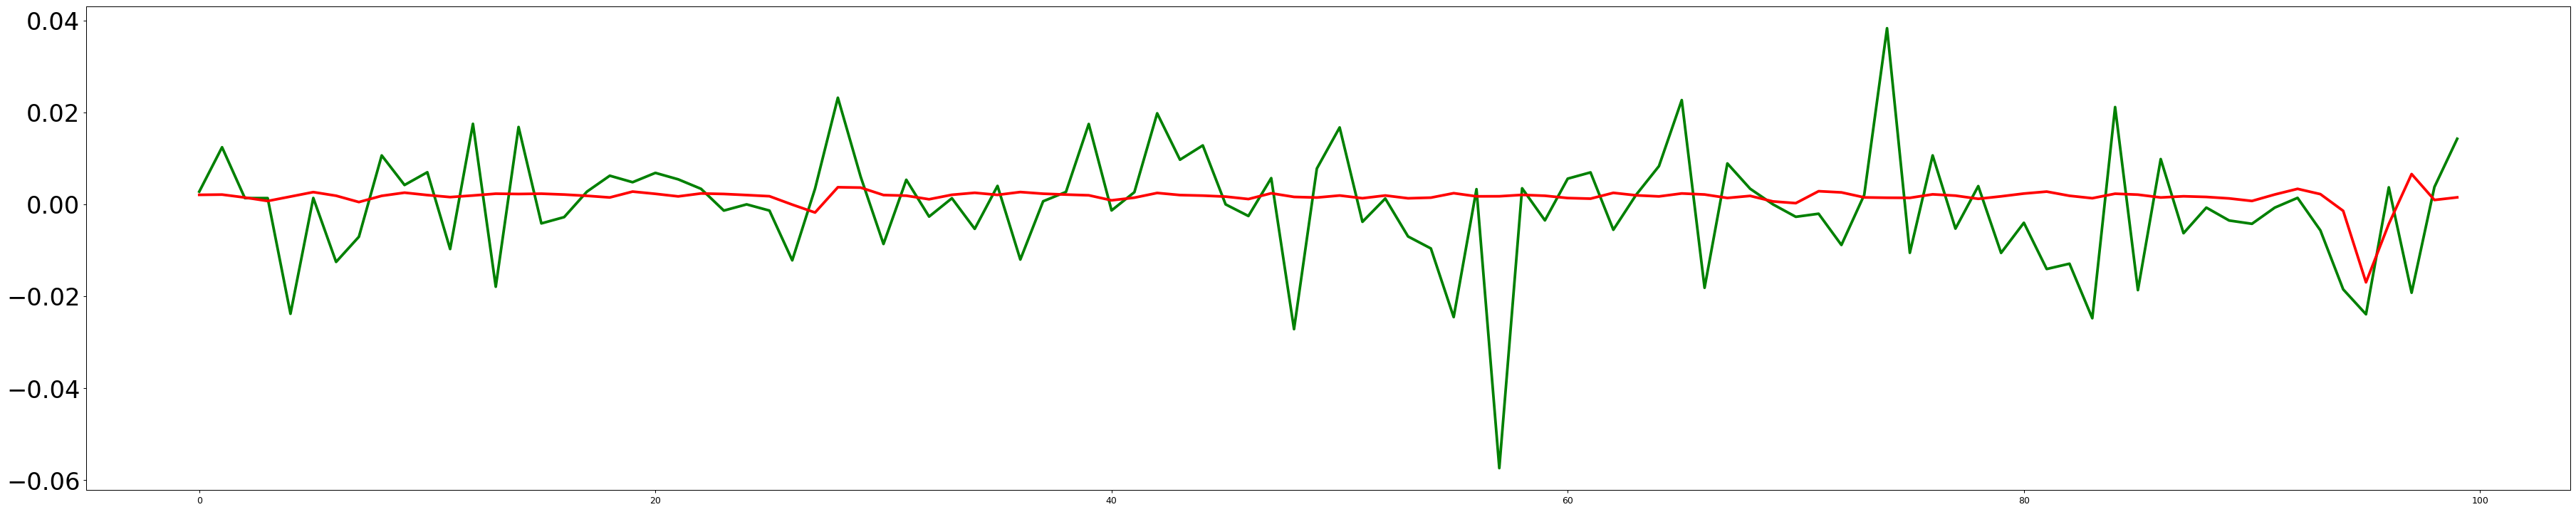

In [152]:
fig1, ax1 = plt.subplots(figsize=(50, 10), dpi=90)
ax1.tick_params(axis='y', which='both',    
                labeltop='on', labelbottom='off', labelsize=27)
ax1.plot(y_test, 'g', lw=3)
ax1.plot(y_pred,'r', lw=3)

In [79]:
from covid19dh import covid19
import matplotlib.pyplot as plt

train_start = '2017-01-04'
train_end = '2021-12-03'
eval_start = '2022-07-05'
eval_end = '2022-10-07'

def base_plot(data,title,source):
    plt.plot(data);
    plt.title(f'{title} - {source}');
    plt.show()
    
def context_plot(data,title,source,start_plot='2010-01-01',
                 train_start=train_start, train_end=train_end,
                 eval_start=eval_start, eval_end=eval_end):
    data = data[data.index>start_plot]
    plt.plot(data);
    plt.title(f'{title} - {source}');
    plt.axvspan(train_start, train_end, color="grey", alpha=0.25)
    plt.axvspan(eval_start, eval_end, color="grey", alpha=0.5)
    plt.hlines(0,xmin=data.index.min(),xmax=pd.to_datetime(eval_end),color='k',linestyles='dotted');
    plt.show()

x, src = covid19("Japan")
x = x.set_index('date')

We have invested a lot of time and effort in creating COVID-19 Data Hub, please cite the following when using it:

	Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.

A BibTeX entry for LaTeX users is

	@Article{,
		title = {COVID-19 Data Hub},
		year = {2020},
		doi = {10.21105/joss.02376},
		author = {Emanuele Guidotti and David Ardia},
		journal = {Journal of Open Source Software},
		volume = {5},
		number = {51},
		pages = {2376},
	}

To hide this message use 'verbose = False'.


C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\covid19dh\_cite.py:85: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  src = src.append(sources[
C:\Users\user\AppData\Local\Programs\Python\Python310\lib\site-packages\covid19dh\_cite.py:96: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  references = references.append(src)


In [99]:
x['deffDeaths'] = x['deaths'].diff().rolling(7).mean()